INTRODUCTION

In this notebook I analyze the interactions between users and articles of the IBM Watson Studio platform.
The goal is to build a recommendation system, to suggest users some articles they might like.

Index:
1. Data loading and preparation
2. Exploratory analysis
3. Rank based recommendation
4. User-based collaborative filtering
5. Matrix factorization

##### 1) DATA LOADING AND PREPARATION

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [60]:
# Load data
user_item_df = pd.read_csv('user-item-interactions.csv')
articles_df = pd.read_csv('articles_community.csv')

del user_item_df['Unnamed: 0']
del articles_df['Unnamed: 0']

In [61]:
user_item_df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [62]:
articles_df.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [63]:
# I want to have a unique article_id in each row.
articles_df.drop_duplicates(subset="article_id", inplace=True)
assert sum(articles_df.duplicated()) == 0; print("No more duplicates here!")

No more duplicates here!


In [64]:
# User Id Transformation
# Since user_ids are currently represented by an alphanumeric long string, we can transform it into a simpler index.
def email_mapper(df):
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

print(len(user_item_df['email'].dropna().unique()))
email_encoded = email_mapper(user_item_df)
del user_item_df['email']
user_item_df['user_id'] = email_encoded
user_item_df.head()
print(len(user_item_df['user_id'].dropna().unique()))

5148
5149


In [41]:
user_item_df[user_item_df.duplicated()]

,article_id,title,email
41,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
75,1429.0,use deep learning for image classification,3c2de1b0a92728aa53064a22ff7bd7319878ed95
95,1162.0,analyze energy consumption in buildings,d385b6c44711688ce2a33eb596495bf9243e1750
97,409.0,using github for project control in dsx,2b6c0f514c2f2b04ad3c4583407dccd0810469ee
99,1393.0,the nurse assignment problem,8dc8d7ec2356b1b106eb3d723f3c234e03ab3f1e
...,...,...,...
45972,588.0,tidyr 0.6.0,0f3f3b558c7a821ef18092c48ea924aff362ec53
45973,1398.0,total population by country,0f3f3b558c7a821ef18092c48ea924aff362ec53
45979,962.0,data visualization with r: scrum metrics,1b7a3f70a30b90837681376d48c1ae8832f9834b
45982,1324.0,ibm watson facebook posts for 2015,d21b998d7a4722310ceeaa3c6aaa181a36db2d73


##### 2) EXPLORATORY ANALYSIS

In [65]:
# Find the distribution of how many articles a user interacts with
user_article = np.empty((len(user_item_df['user_id'].unique())))
for u, user in enumerate(user_item_df['user_id'].unique()):
    user_article[u] = (user_item_df['user_id'] == user).sum()

# Compute median of distribution
median_val = np.percentile(user_article,50)
print(f"Median of distribution : {median_val}")

# Compute max value of distribution
max_views_by_user = np.max(user_article)
print(f"Max value of distribution : {max_views_by_user}")

# Compute # of articles with at least one interaction
unique_articles = len(user_item_df['article_id'].unique())
print(f"# of unique articles with at least one interaction : {unique_articles}")

# Compute # of total articles
total_articles = articles_df.shape[0]
print(f"# of total articles : {total_articles}")

# Compute # of total users
unique_users = len(user_item_df['user_id'].unique()) - 1    # -1 comes because the email wrapper function considers the NaN value in the email field as a user
print(f"# of total users : {unique_users}")

# Compute # of user-article interactions
user_article_interactions = user_item_df.shape[0]
print(f"# of user-article interactions : {user_article_interactions}")

# Compute the id the most viewed article in the dataset
most_viewed_article_id = str(user_item_df['article_id'].value_counts().index[0])
print(f"Id the most viewed article in the dataset : {most_viewed_article_id}")

# Compute # views of the most viewd article
max_views = user_item_df['article_id'].value_counts()[float(most_viewed_article_id)]
print(f"# views of the most viewd article : {max_views}")

Median of distribution : 3.0
Max value of distribution : 364.0
# of unique articles with at least one interaction : 714
# of total articles : 1051
# of total users : 5148
# of user-article interactions : 45993
Id the most viewed article in the dataset : 1429.0
# views of the most viewd article : 937


##### 3) RANK BASED RECOMMENDATION

In [8]:
def get_top_article_ids(n, df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    count = df['article_id'].value_counts()
    top_articles = list(count.index[:n].values)
 
    return top_articles


def get_top_articles(n, df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_indexes = get_top_article_ids(n, df=df)
    top_articles = [df['title'][df['article_id']==t].values[0] for t in top_indexes]
        
    return top_articles

In [9]:
# Check top 5 articles
for n, (id, title) in enumerate(zip(get_top_article_ids(5, user_item_df), get_top_articles(5, user_item_df))):
    print(f"{n+1}° Placed - Article Id: {id} - Title: '{title}'.")

1° Placed - Article Id: 1429.0 - Title: 'use deep learning for image classification'.
2° Placed - Article Id: 1330.0 - Title: 'insights from new york car accident reports'.
3° Placed - Article Id: 1431.0 - Title: 'visualize car data with brunel'.
4° Placed - Article Id: 1427.0 - Title: 'use xgboost, scikit-learn & ibm watson machine learning apis'.
5° Placed - Article Id: 1364.0 - Title: 'predicting churn with the spss random tree algorithm'.


##### 4) USER-BASED COLLABORATIVE FILTERING

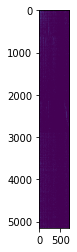

In [10]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    unique_users = df['user_id'].unique()
    unique_articles = df['article_id'].unique()
    user_item = np.zeros((len(unique_users), len(unique_articles)))
    for u, user in enumerate(unique_users):
        articles_seen_by_user = df['article_id'][df['user_id'] == user].values
        for article in articles_seen_by_user:
            a = np.where(df['article_id'].unique() == article)[0]
            user_item[u, a] = 1

    return pd.DataFrame(user_item, index=unique_users, columns=unique_articles)

user_item = create_user_item_matrix(user_item_df)
plt.imshow(user_item)

In [11]:
def find_similar_users(user_id, user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # Compute similarity of each user to the provided user
    most_similar_users = (user_item * user_item.loc[user_id,:]).mean(axis=1)

    # Sort by similarity
    most_similar_users = most_similar_users.sort_values(ascending=False)

    # Create list of just the ids
    most_similar_users = list(most_similar_users.index)
   
    # Remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users

In [12]:
selected_user = 1
print(f"Top 10 users most similar to user {selected_user} : {find_similar_users(selected_user, user_item)[:10]}")

Top 10 users most similar to user 1 : [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]


In [13]:
def get_article_names(article_ids, df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_names = [user_item_df.loc[user_item_df['article_id'] == float(article)].iloc[0,:]['title'] for article in article_ids]
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item.loc[user_id,:][user_item.loc[user_id,:] == 1].index
    article_ids=[str(i) for i in article_ids]
    article_names = get_article_names(article_ids, user_item_df)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recs = []
    similars_users = find_similar_users(user_id, user_item)
    for user in similars_users:
        not_seen = user_item.columns[(user_item.loc[user,:] - user_item.loc[user_id,:]) == 1].values
        if len(not_seen) > 0:
            for new_moovie in not_seen:
                #recs.append(f"Moovie_id: {new_moovie} - Title: {(get_article_names([new_moovie], user_item_df))[0].capitalize()}")
                recs.append(new_moovie)
                if len(recs) >= m:
                    return recs # return your recommendations for this user_id    

In [14]:
user_user_recs(1, m=10)

[1314.0, 1338.0, 1276.0, 1432.0, 14.0, 1395.0, 12.0, 1393.0, 362.0, 1364.0]

In [87]:
def get_top_sorted_users(user_id, df, user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Compute similarity of each user to the provided user
    most_similar_users = (user_item * user_item.loc[1,:]).mean(axis=1)

    # Sort by similarity
    most_similar_users = most_similar_users.sort_values(ascending=False)

    # Remove the own user's id
    most_similar_users = most_similar_users.drop(index=user_id)

    # Create a dataframe
    neighbors_df = pd.DataFrame(most_similar_users, columns=['similarity'])

    # Add the number of interactions for each user in the dataframe
    neighbors_df['num_interactions'] = [user_item_df.value_counts('user_id')[user_id] for user_id in most_similar_users.index]

    # Sort the dataframe by similarity and then by interactions
    neighbors_df = neighbors_df.sort_values(['similarity', 'num_interactions'], ascending=False)

    # Create a column with user_id
    neighbors_df['neighbor_id'] = neighbors_df.index
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    recs = []
    similars_users = list(get_top_sorted_users(user_id, user_item_df, user_item).index)
    for user in similars_users:
        not_seen = user_item.columns[(user_item.loc[user,:] - user_item.loc[user_id,:]) == 1].values

        # Sort articlesby number of interactions
        sorted_article = pd.DataFrame(not_seen, columns=['article_id'])
        sorted_article['num_interactions'] = [user_item_df.value_counts('article_id')[article_id] for article_id in not_seen]
        sorted_article = sorted_article.sort_values(['num_interactions'], ascending=False)
        sorted_not_seen = sorted_article['article_id'].values

        if len(not_seen) > 0:
            for new_moovie in not_seen:
                recs.append(new_moovie)
                if len(recs) >= m:
                    rec_names = get_article_names(recs, user_item_df)
                    return recs, rec_names

In [88]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1430.0, 1429.0, 1185.0, 1170.0, 1052.0, 1431.0, 1427.0, 1368.0, 1305.0, 1436.0]

The top 10 recommendations for user 20 are the following article names:
['using pixiedust for fast, flexible, and easier data analysis and experimentation', 'use deep learning for image classification', 'classify tumors with machine learning', 'apache spark lab, part 1: basic concepts', 'access db2 warehouse on cloud and db2 with python', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'gosales transactions for naive bayes model', 'welcome to pixiedust']


##### 5) MATRIX FACTORIZATION

In [106]:
u, s, vt = np.linalg.svd(user_item, full_matrices=True)

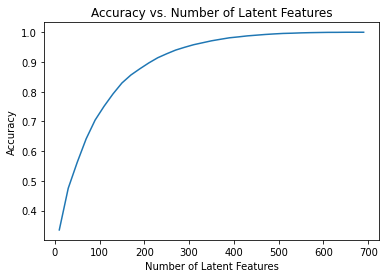

In [109]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/user_item_df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [122]:
print(user_item.shape)
print(u_new.shape)
print(s_new.shape)
print(vt_new.shape)

(5149, 714)
(5149, 690)
(690, 690)
(690, 714)


In [123]:
df_train = user_item_df.head(40000)
df_test = user_item_df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train = create_user_item_matrix(df_train)
    
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index
    test_arts = user_item.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [124]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=True) # fit svd similar to above then use the cells below

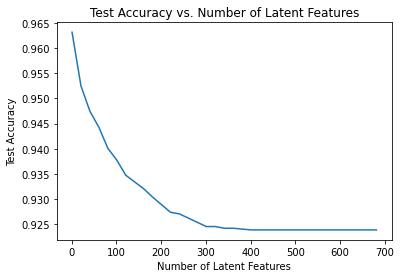

In [168]:
num_latent_feats = np.arange(1,700,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

    users_to_predict = np.intersect1d(user_item_train.index, user_item_test.index, assume_unique=True)
    movies_to_predict = user_item_test.columns
    predicted = user_item_est[user_item_train.index.isin(users_to_predict),:]
    predicted = predicted[:,user_item_train.columns.isin(movies_to_predict)]
    targets = user_item_test.loc[user_item_test.index.isin(users_to_predict),:]
    
    # compute error for each prediction to actual value
    diffs = np.subtract(targets, predicted)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df_test.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Test Accuracy');
plt.title('Test Accuracy vs. Number of Latent Features');